In [60]:
import pennylane as qml 
from pennylane import numpy as np 
from pennylane.templates import RandomLayers 
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt

n_epochs = 30 # Number of optimization epochs
# n_layers = 1 # Number of random Layers
n_layers = 2 # Add more random layers
n_train = 50 # Size of the train dataset
n_test = 30 # Size of the test dataset

SAVE_PATH = "./" # Data saving folder 
PREPROCESS = True # If False, skip quantum processihgjghng and load data from SAVE_PATH 
np.random.seed(0) # Seed for Numpy random number generator 
tf.random.set_seed(0) # Seed for TensorFlow random number generator

In [61]:
mnist_dataset = keras.datasets.mnist 
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size 
train_images = train_images[:n_train] 
train_labels = train_labels[:n_train] 
test_images = test_images[:n_test] 
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1 
train_images = train_images / 255 
test_images = test_images / 255
# Add extra dimension for convolution channels 
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False) 
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [62]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters 
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

@qml.qnode(dev) 
def circuit (phi):
    # Encoding of 4 classical input values 
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit 
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values 
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [63]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit.""" 
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2x2 squares 
    for j in range(0, 28, 2): 
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit 
            q_results = circuit(
                [
                    image[j, k, 0], 
                    image[j, k + 1, 0], 
                    image[j + 1, k, 0], 
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2) 
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c] 
    return out

In [64]:
if PREPROCESS == True:
    q_train_images = [] 
    print("Quantum pre-processing of train images:") 
    for idx, img in enumerate(train_images):
        print("{}/{}    ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img)) 
    q_train_images = np.asarray(q_train_images)

    q_test_images = [] 
    print("\nQuantum pre-processing of test images:") 
    for idx, img in enumerate(test_images): 
        print("{}/{}    ".format(idx + 1, n_test), end="\r") 
        q_test_images.append(quanv(img)) 
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images 
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images) 
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images 
q_train_images = np.load(SAVE_PATH + "q_train_images.npy") 
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50    
Quantum pre-processing of test images:


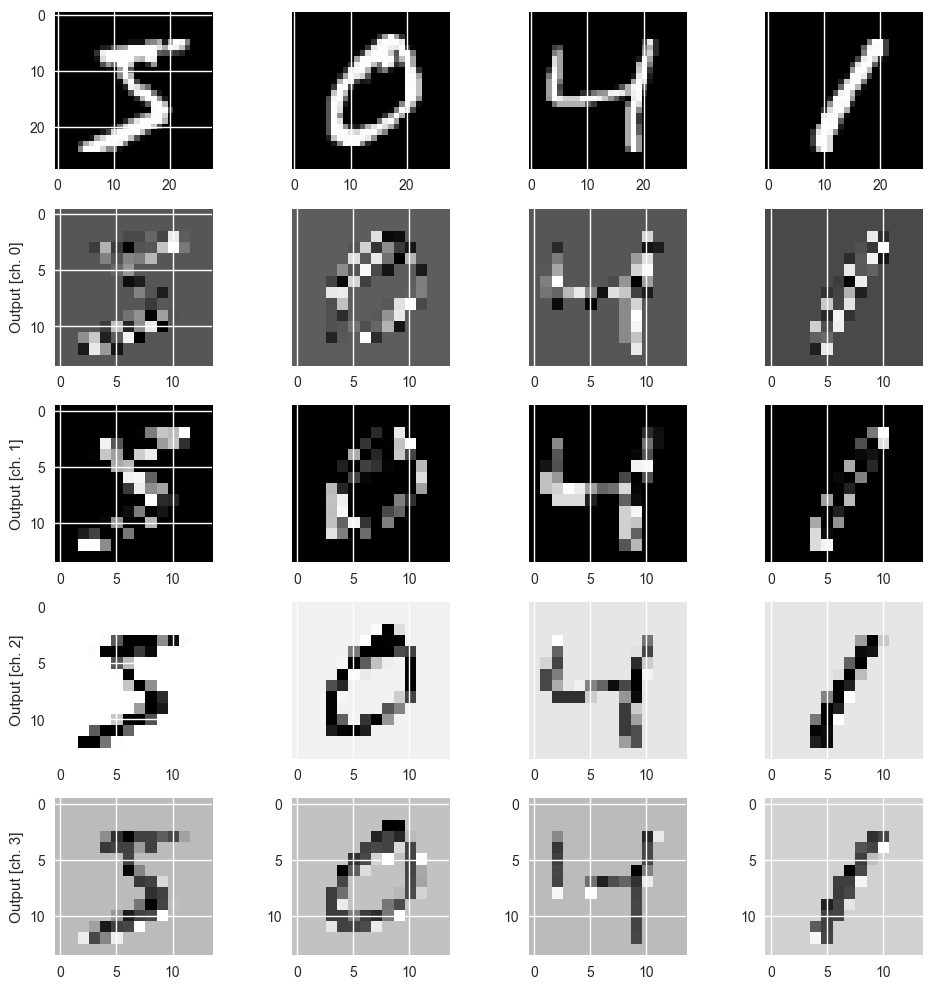

In [65]:
n_samples = 4 
n_channels = 4 
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10)) 
for k in range(n_samples):
    axes[0, 0].set_label("Input") 
    if k != 0:
        axes[0, k].yaxis.set_visible(False) 
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels 
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c)) 
        if k != 0:
            axes[c, k].yaxis.set_visible(False) 
        axes [c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt. tight_layout() 
plt.show()

In [66]:
def MyModel():
    """Initializes and returns a custom Keras model which is ready to be trained.""" 
    model = keras.models.Sequential([
        keras.layers.Flatten(), 
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'],
    )
    return model

In [67]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images, 
    train_labels, 
    validation_data=(q_test_images, test_labels), 
    batch_size=4, 
    epochs=n_epochs, 
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.6831 - accuracy: 0.0800 - val_loss: 2.3362 - val_accuracy: 0.1333 - 255ms/epoch - 20ms/step
Epoch 2/30
13/13 - 0s - loss: 2.1025 - accuracy: 0.1800 - val_loss: 2.1931 - val_accuracy: 0.2000 - 24ms/epoch - 2ms/step
Epoch 3/30
13/13 - 0s - loss: 1.8642 - accuracy: 0.4000 - val_loss: 2.0796 - val_accuracy: 0.2667 - 23ms/epoch - 2ms/step
Epoch 4/30
13/13 - 0s - loss: 1.5934 - accuracy: 0.5800 - val_loss: 1.9441 - val_accuracy: 0.3333 - 24ms/epoch - 2ms/step
Epoch 5/30
13/13 - 0s - loss: 1.3942 - accuracy: 0.6800 - val_loss: 1.8206 - val_accuracy: 0.4667 - 24ms/epoch - 2ms/step
Epoch 6/30
13/13 - 0s - loss: 1.2514 - accuracy: 0.8000 - val_loss: 1.8127 - val_accuracy: 0.4667 - 24ms/epoch - 2ms/step
Epoch 7/30
13/13 - 0s - loss: 1.0563 - accuracy: 0.8600 - val_loss: 1.7395 - val_accuracy: 0.5000 - 24ms/epoch - 2ms/step
Epoch 8/30
13/13 - 0s - loss: 0.9186 - accuracy: 0.9600 - val_loss: 1.6267 - val_accuracy: 0.5667 - 24ms/epoch - 2ms/step
Epoch 9/30
13/13 - 0s 

In [68]:
c_model = MyModel()

c_history = c_model.fit(
    train_images, 
    train_labels, 
    validation_data=(test_images, test_labels), 
    batch_size=4, 
    epochs=n_epochs, 
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 2.4343 - accuracy: 0.1200 - val_loss: 2.2468 - val_accuracy: 0.2000 - 249ms/epoch - 19ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0592 - accuracy: 0.3200 - val_loss: 2.1046 - val_accuracy: 0.1667 - 24ms/epoch - 2ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7511 - accuracy: 0.5400 - val_loss: 1.9679 - val_accuracy: 0.2000 - 24ms/epoch - 2ms/step
Epoch 4/30
13/13 - 0s - loss: 1.5056 - accuracy: 0.6200 - val_loss: 1.8380 - val_accuracy: 0.3000 - 24ms/epoch - 2ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2941 - accuracy: 0.8000 - val_loss: 1.7167 - val_accuracy: 0.4333 - 24ms/epoch - 2ms/step
Epoch 6/30
13/13 - 0s - loss: 1.1217 - accuracy: 0.8600 - val_loss: 1.6289 - val_accuracy: 0.5333 - 24ms/epoch - 2ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9749 - accuracy: 0.9000 - val_loss: 1.5580 - val_accuracy: 0.5667 - 24ms/epoch - 2ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8510 - accuracy: 0.9200 - val_loss: 1.4893 - val_accuracy: 0.6333 - 24ms/epoch - 2ms/step
Epoch 9/30
13/13 - 0s 

C:\Users\huyth\AppData\Local\Temp\ipykernel_7372\197022215.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


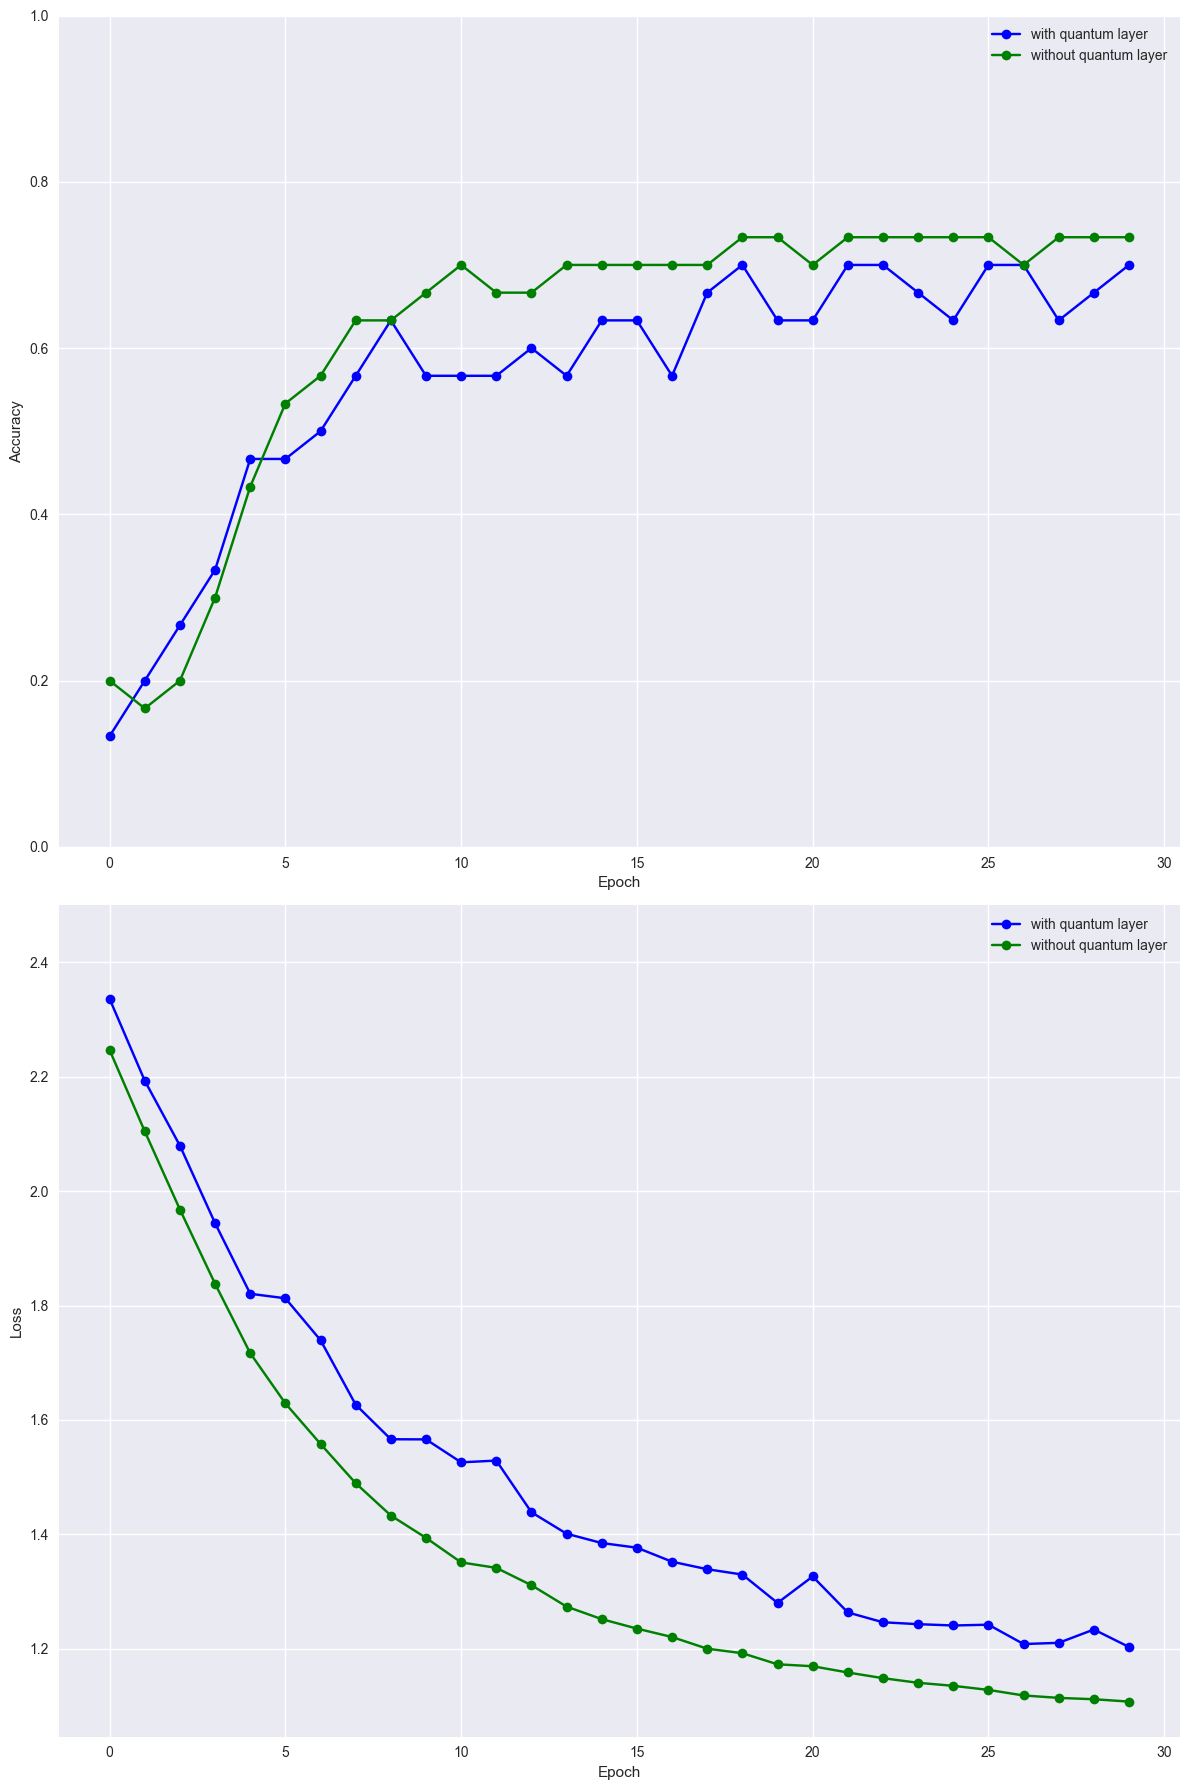

In [69]:
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 18))

ax1.plot(q_history.history['val_accuracy'], '-ob', label='with quantum layer')
ax1.plot(c_history.history['val_accuracy'], '-og', label='without quantum layer')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(q_history.history['val_loss'], '-ob', label='with quantum layer')
ax2.plot(c_history.history['val_loss'], '-og', label='without quantum layer')
ax2.set_ylabel('Loss')
ax2.set_ylim(top=2.5)
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()